<a href="https://colab.research.google.com/github/jeroenzwan/MAV_course/blob/main/4corners_Jeroen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train YOLOv5 on Custom Objects

This notebook is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook is adapted from the [roboflow tutorial](https://models.roboflow.com/object-detection/yolov5).




#Install Dependencies

Add the yolov5s_jeroen_z.zip from https://github.com/jeroenzwan/MAV_course to the content folder and wait till this is added before executing next command. Here the trained YOLOv5s network is unzipped. 

In [22]:
!unzip yolov5s_jeroen_z.zip

Archive:  yolov5s_jeroen_z.zip
   creating: yolov5/
   creating: yolov5/utils/
   creating: yolov5/utils/wandb_logging/
 extracting: yolov5/utils/wandb_logging/__init__.py  
  inflating: yolov5/utils/wandb_logging/wandb_utils.py  
  inflating: yolov5/utils/wandb_logging/log_dataset.py  
  inflating: yolov5/utils/google_utils.py  
 extracting: yolov5/utils/__init__.py  
  inflating: yolov5/utils/datasets.py  
   creating: yolov5/utils/aws/
 extracting: yolov5/utils/aws/__init__.py  
  inflating: yolov5/utils/aws/userdata.sh  
  inflating: yolov5/utils/aws/mime.sh  
  inflating: yolov5/utils/aws/resume.py  
  inflating: yolov5/utils/autoanchor.py  
  inflating: yolov5/utils/plots.py   
  inflating: yolov5/utils/metrics.py  
   creating: yolov5/utils/google_app_engine/
  inflating: yolov5/utils/google_app_engine/app.yaml  
  inflating: yolov5/utils/google_app_engine/Dockerfile  
  inflating: yolov5/utils/google_app_engine/additional_requirements.txt  
  inflating: yolov5/utils/general.py 

In [24]:
# Switch working directory
%cd yolov5

/content/yolov5


In [25]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 645kB 19.5MB/s 
Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Download Correctly Formatted Custom Dataset 

The dataset labels were generated using the python script .... This data needs to be imported into Roboflow and the corner bounding boxes adjusted to better fit the image. This then needs to be exported with the "**YOLOv5 PyTorch**" export format using the "Show download code" option. We'll download our dataset from Roboflow. The Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [26]:
# Switch working directory and download the dataset from RoboFlow.
%cd /content
!curl -L "https://app.roboflow.com/ds/42FCY4aDoc?key=1AccWEadZT" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1743      0 --:--:-- --:--:-- --:--:--  1739
100 21.0M  100 21.0M    0     0  23.2M      0 --:--:-- --:--:-- --:--:-- 23.2M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img_12_jpg.rf.7d3592ab56e0e7def1293e0994ff5918.jpg  
 extracting: test/images/img_132_jpg.rf.b48d35a8cdbf94d20aa69ec40d993862.jpg  
 extracting: test/images/img_136_jpg.rf.ad61762741b670d1e5006483dcfffabd.jpg  
 extracting: test/images/img_137_jpg.rf.584bdd45ce634f44b0cb576c01f30133.jpg  
 extracting: test/images/img_139_jpg.rf.f58636ddce534f92b952abb8824ab670.jpg  
 extracting: test/images/img_153_jpg.rf.a27dac24d697d16c3f51624ab120ce4f.jpg  
 extracting: test/images/img_154_jpg.rf.bd37c4dbc9044122ff

In [27]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 4
names: ['bottomLeft', 'bottomRight', 'topLeft', 'topRight']

# Define Model Configuration and Architecture

Writing a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

In [28]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [29]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [30]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Here starts the training, this can be skipped since there is already a network trained.


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [8]:
# train yolov5s on custom data for 50 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: ⚠️ WARNING: code is out of date by 140 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', entity=None, epochs=50, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdi

# Evaluate Custom YOLOv5 Detector Performance

Here different values of the YOLOv5s network can be seen.

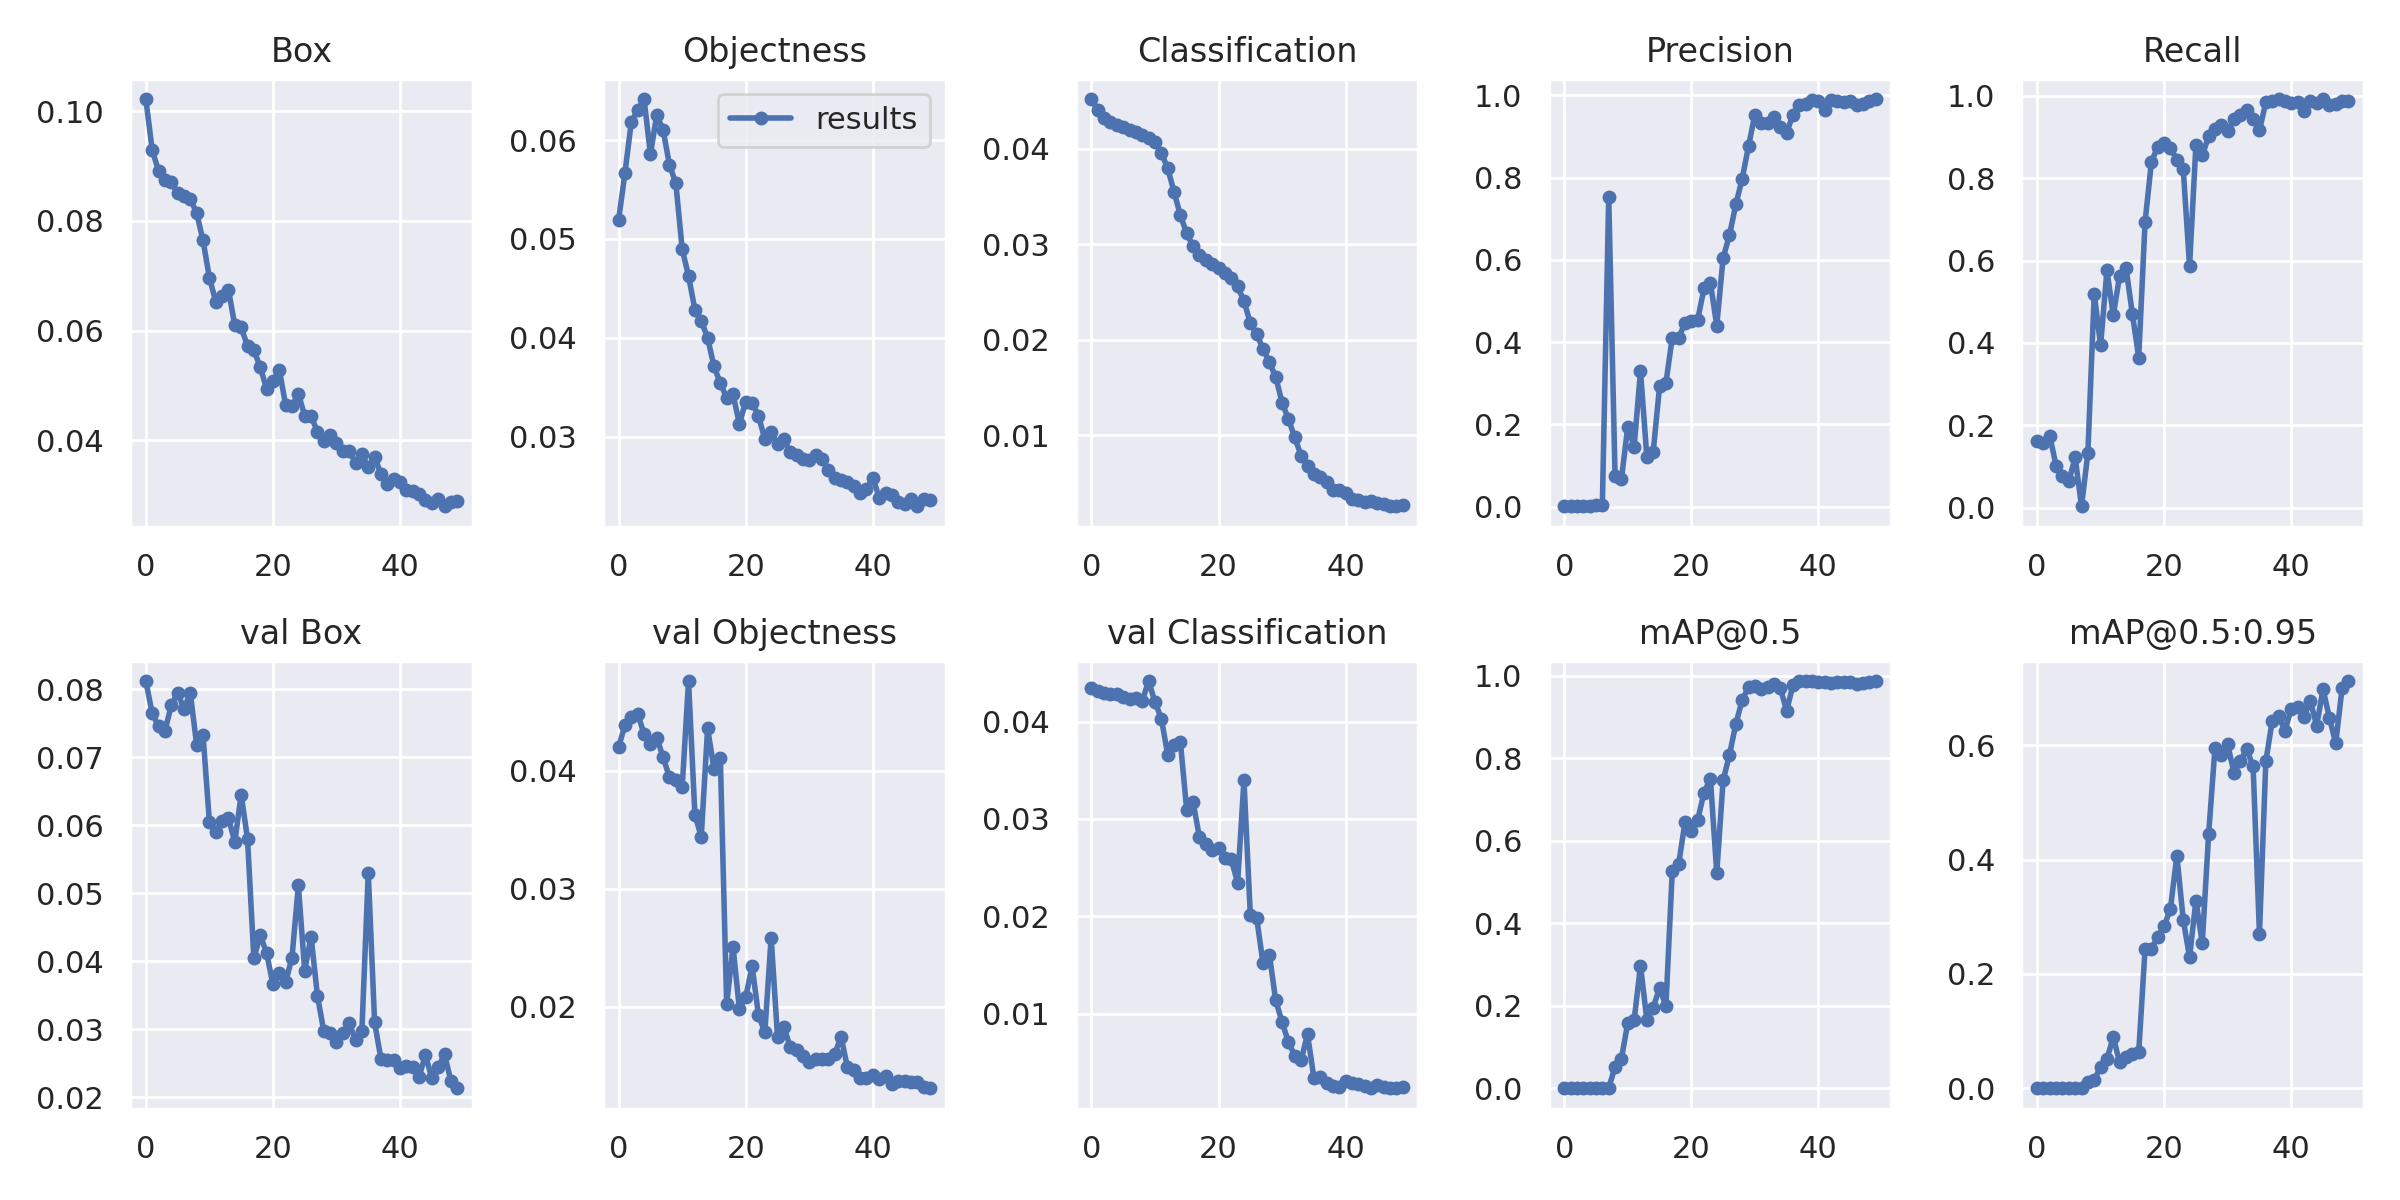

In [32]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

#Run Inference  With Trained Weights

##This step can also be skipped, since there are already detected test images generated.

In [33]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --save-txt --save-conf --conf 0.6 --source ../test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.6, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='../test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7254609 parameters, 0 gradients, 16.8 GFLOPS
image 1/31 /content/yolov5/../test/images/img_12_jpg.rf.7d3592ab56e0e7def1293e0994ff5918.jpg: 416x416 1 bottomLeft, 1 bottomRight, 1 topLeft, 1 topRight, Done. (0.039s)
image 2/31 /content/yolov5/../test/images/img_132_jpg.rf.b48d35a8cdbf94d20aa69ec40d993862.jpg: 416x416 1 bottomLeft, 1 bottomRight, 1 topLeft, 1 topRight, Done. (0.009s)
image 3/31 /content/yolov5/../test/images/img_136_jpg.rf.ad61762741b670d1e5006483dcfffabd.jpg: 416x416 1 bottomLeft, 1 bottomRight, 1 topLeft, 1 topRight, Done. (0.009s)
im

Here the test images are evaluated and the PR_curve and other plots are saved to the /runs/test/exp folder.

In [26]:
!python test.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --save-txt --save-conf --conf 0.6 --data 'test_data.yaml'

Namespace(augment=False, batch_size=32, conf_thres=0.6, data='test_data.yaml', device='', exist_ok=False, img_size=416, iou_thres=0.6, name='exp', project='runs/test', save_conf=True, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='val', verbose=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7254609 parameters, 0 gradients, 16.8 GFLOPS
val: Scanning '../test/labels' for images and labels... 31 found, 0 missing, 0 empty, 0 corrupted: 100% 31/31 [00:00<00:00, 2315.11it/s]
val: New cache created: ../test/labels.cache
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 1/1 [00:00<00:00,  1.44it/s]
                 all          31         124           1       0.992       0.993       0.711
          bottomLeft          31          31           1       0.968       0.973       0.682
    

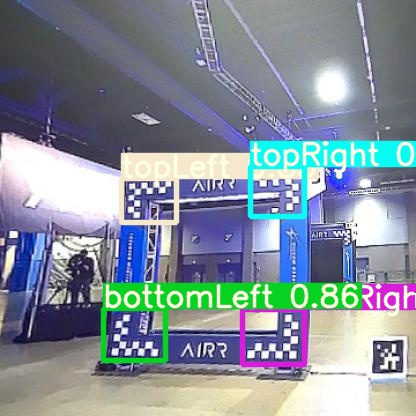

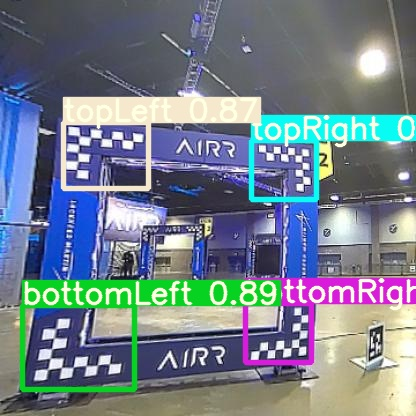

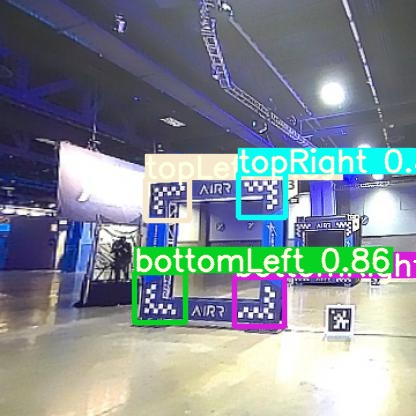

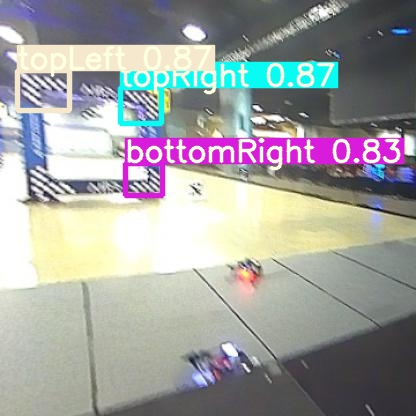

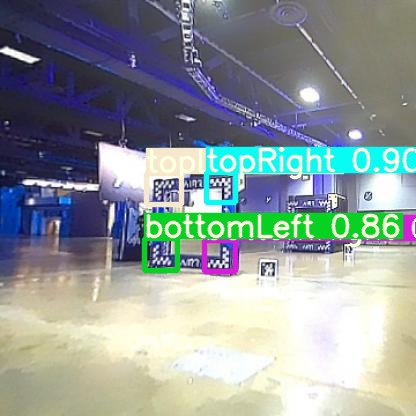

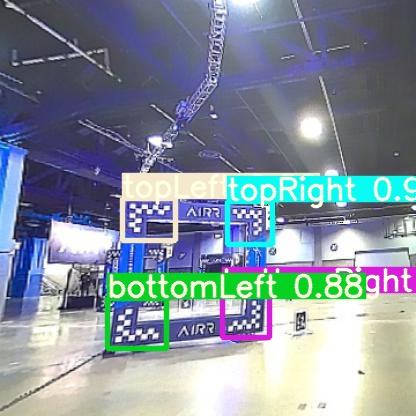

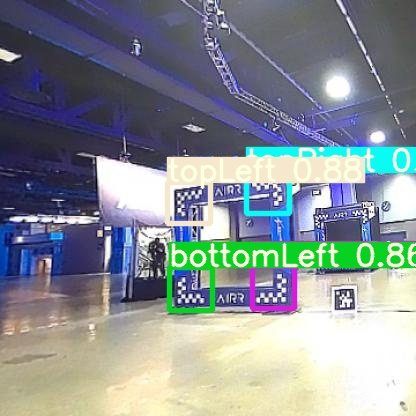

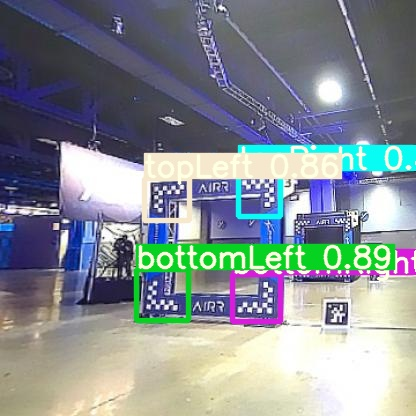

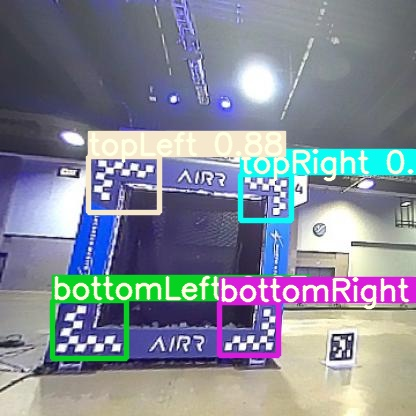

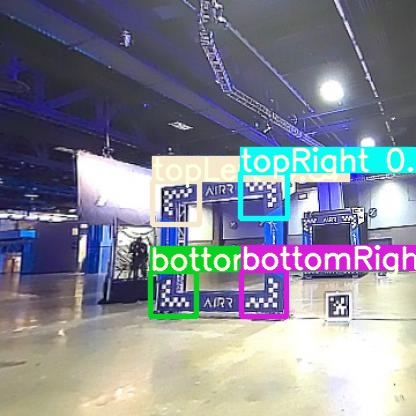

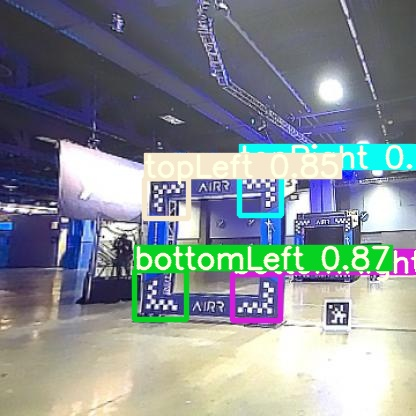

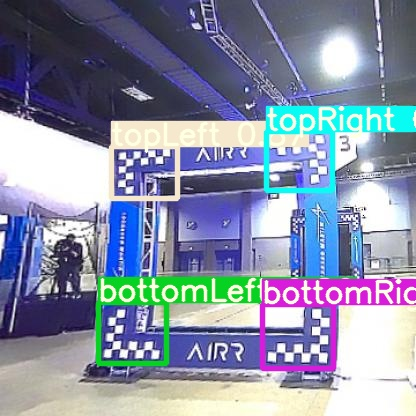

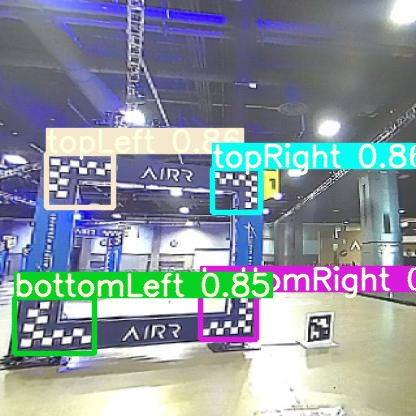

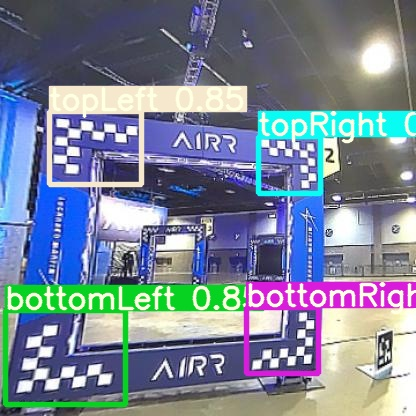

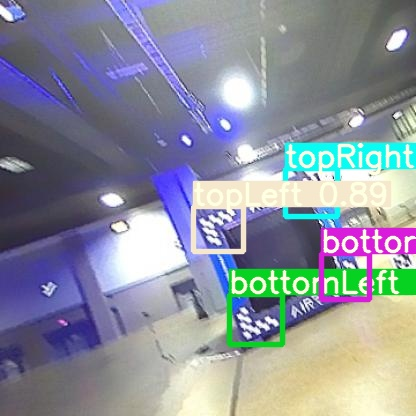

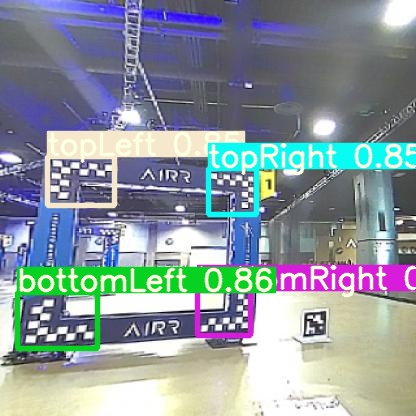

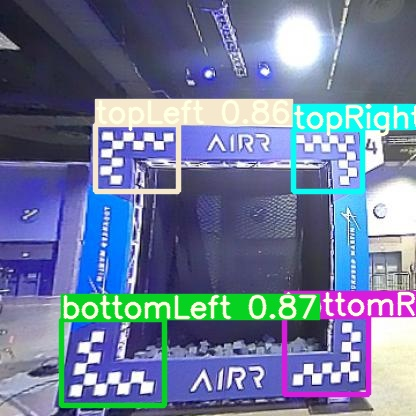

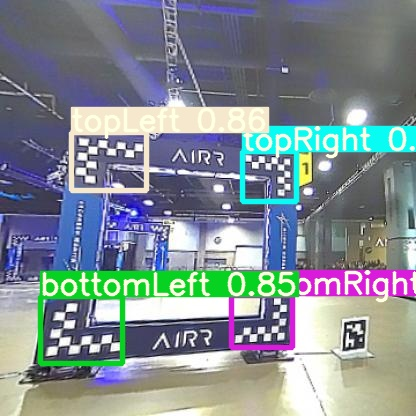

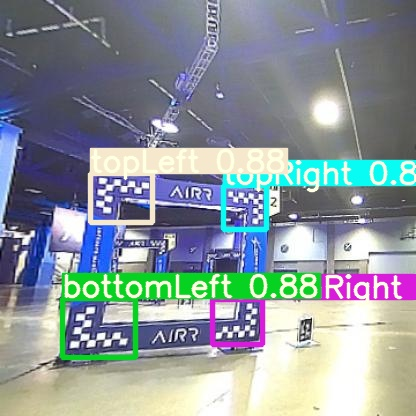

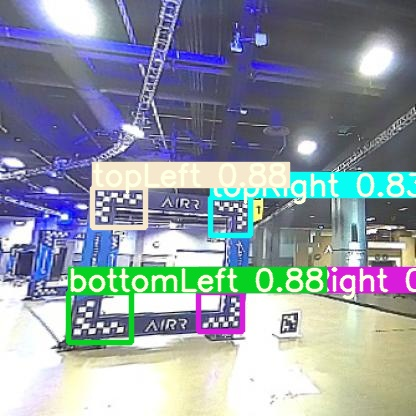

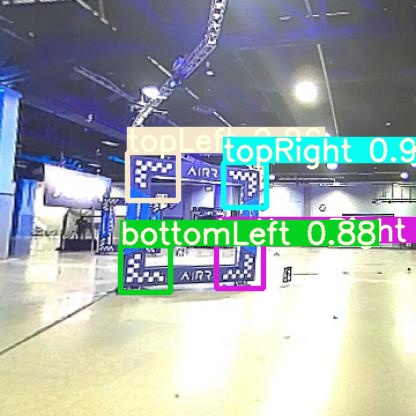

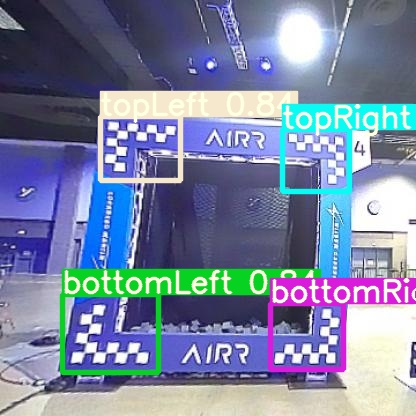

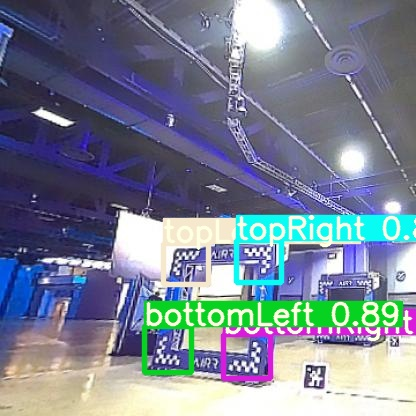

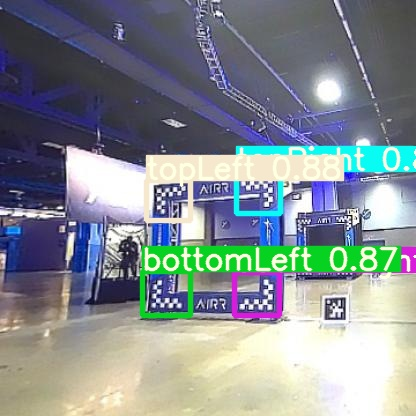

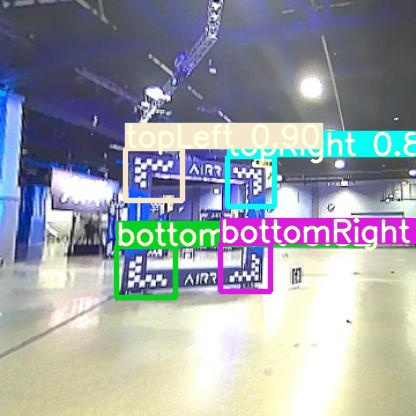

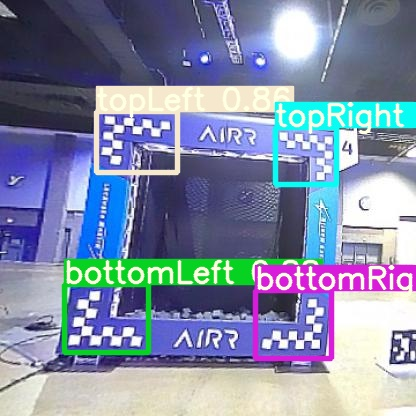

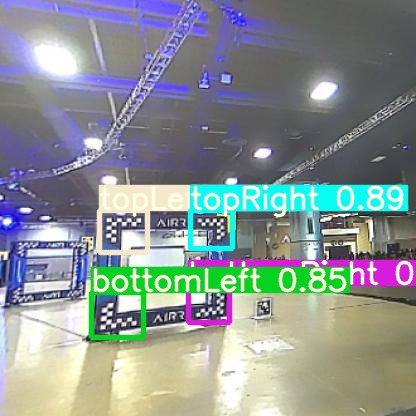

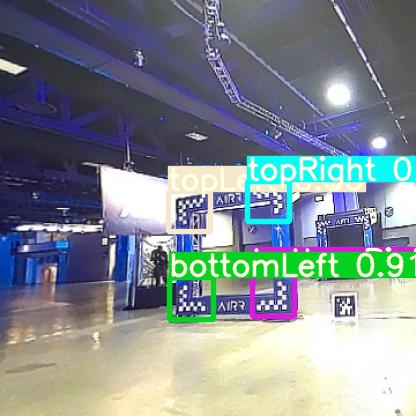

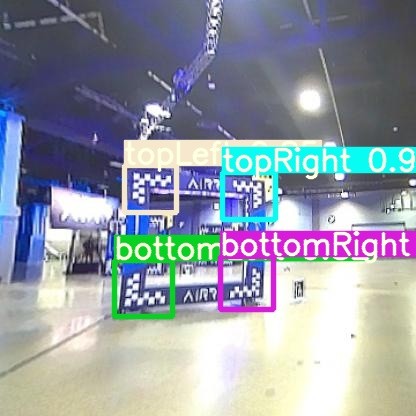

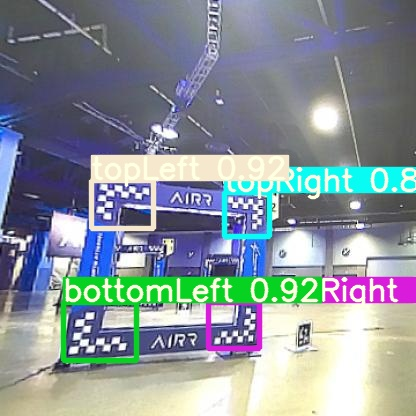

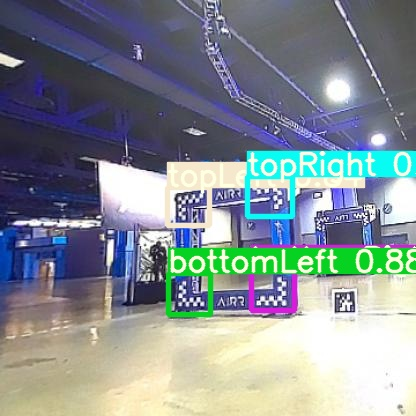

In [39]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

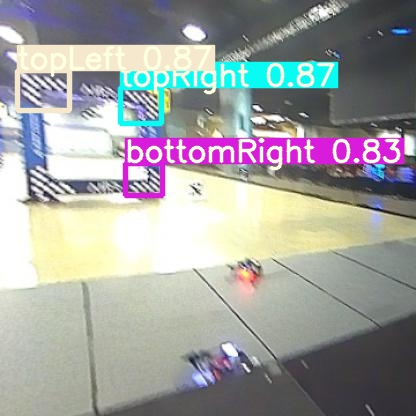

In [44]:
# Search through images in the test set which contain wrong classified corners and display.

import os
import numpy as np
all_files = os.listdir('/content/yolov5/runs/detect/exp/labels/')
true_labels_folder = '/content/test/labels/'
pred_labels_folder = '/content/yolov5/runs/detect/exp/labels/'
for fileName in all_files:
  true_labels = np.loadtxt(true_labels_folder+fileName)
  pred_labels = np.loadtxt(pred_labels_folder+fileName)

  for i in range(true_labels.shape[0]):
    for j in range(pred_labels.shape[0]):
      if true_labels[i,0]==pred_labels[j,0]:
        for k in range(4):
          diff = true_labels[i,k+1]-pred_labels[j,k+1]
          if diff>0.03:
            display(Image(filename='/content/yolov5/runs/detect/exp/'+fileName[:-4]+'.jpg'))